# 네이버 키워드 = 텐트

In [1]:
import sys
import os
import pymysql
import base64
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup as BS
from urllib.request import Request, urlopen
import lxml.html
import re
import pickle
import pyarrow.parquet as pq
from pyarrow import csv
import pandavro
import urllib.request
from tqdm import tqdm_notebook
import boto3
import mimetypes

# <네이버 쇼핑 텐트 키워드로 검색되는 상품 5개 페이지의 상품 정보 받기>

In [125]:
def get_prdinfo_5pages_to_DF():
    cookies = {
    'NNB': 'IDMGADL3MHIWC',
    'AD_SHP_BID': '27',
    '_ga_4BKHBFKFK0': 'GS1.1.1642402376.2.1.1642402379.0',
    'ASID': 'dc763f370000017e66d652af00000061',
    'MM_NEW': '1',
    'NFS': '2',
    '_ga': 'GA1.2.2106199447.1642400290',
    '_ga_7VKFYR6RV1': 'GS1.1.1645429964.2.0.1645429964.60',
    'autocomplete': 'use',
    'nx_ssl': '2',
    'page_uid': 'hFcvXlprvOsss5f/aj0ssssssSK-209943',
    'spage_uid': 'hFcvXlprvOsss5f%2Faj0ssssssSK-209943',
    'sus_val': 'olgrQbsbxvxSrOHxCJov72nv',
    '_naver_usersession_': 'VzGETUYwS8AzxUKZdNDVv1WF',
    'ncpa': '6148|l2e3zkv4|cdf8e41eb25f6af897ae99fe3fa6ed973aebe219|s_124fd409a50b|c1c4719e7921bf013624130d6d96c1956ac7b3b2:159419|l2q3leqw|d29d637475c3859c3ff8bdfddc0341f69b41cec3|s_6cfaa325694b39|f125304f5ffe9eeec2daa4863270e549263696b8:95694|l2qwxs2g|0a14593f652c2860f87deddbfb8959322e0dab93|null|8c263089a86214b3774ae7a32b66c2dbfb7f7f11',
    }

    headers = {
        'authority': 'search.shopping.naver.com',
        'accept': 'application/json, text/plain, */*',
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        # Requests sorts cookies= alphabetically
        # 'cookie': 'NNB=IDMGADL3MHIWC; AD_SHP_BID=27; _ga_4BKHBFKFK0=GS1.1.1642402376.2.1.1642402379.0; ASID=dc763f370000017e66d652af00000061; MM_NEW=1; NFS=2; _ga=GA1.2.2106199447.1642400290; _ga_7VKFYR6RV1=GS1.1.1645429964.2.0.1645429964.60; autocomplete=use; nx_ssl=2; page_uid=hFcvXlprvOsss5f/aj0ssssssSK-209943; spage_uid=hFcvXlprvOsss5f%2Faj0ssssssSK-209943; sus_val=olgrQbsbxvxSrOHxCJov72nv; _naver_usersession_=VzGETUYwS8AzxUKZdNDVv1WF; ncpa=6148|l2e3zkv4|cdf8e41eb25f6af897ae99fe3fa6ed973aebe219|s_124fd409a50b|c1c4719e7921bf013624130d6d96c1956ac7b3b2:159419|l2q3leqw|d29d637475c3859c3ff8bdfddc0341f69b41cec3|s_6cfaa325694b39|f125304f5ffe9eeec2daa4863270e549263696b8:95694|l2qwxs2g|0a14593f652c2860f87deddbfb8959322e0dab93|null|8c263089a86214b3774ae7a32b66c2dbfb7f7f11',
        'logic': 'PART',
        'referer': 'https://search.shopping.naver.com/search/all?frm=NVSCTAB&origQuery=%ED%85%90%ED%8A%B8&pagingIndex=1&pagingSize=40&productSet=total&query=%ED%85%90%ED%8A%B8&sort=rel&timestamp=&viewType=list',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="100", "Google Chrome";v="100"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36',
    }
    
    params = {
            'sort': 'rel',
            'pagingIndex': '',
            'pagingSize': '40',
            'viewType': 'list',
            'productSet': 'total',
            'deliveryFee': '',
            'deliveryTypeValue': '',
            'frm': 'NVSCTAB',
            'query': '텐트',
            'origQuery': '텐트',
            'iq': '',
            'eq': '',
            'xq': '',
        }
    
    
    list_5_pages = []
    for i in range(1, 6): 
        params['pagingIndex'] = i
        response = requests.get('https://search.shopping.naver.com/api/search/all', 
                                params=params, cookies=cookies, headers=headers)
        itemlist = json.loads(response.text)
        
        list_page_i = []           
        for j in range(len(itemlist['shoppingResult']['products'])):       
            
            list_by_page = []

            # id
            list_by_page.append(itemlist['shoppingResult']['products'][j]['id'])

            # 상품명
            list_by_page.append(itemlist['shoppingResult']['products'][j]['productTitle'])

            # 가격
            list_by_page.append(itemlist['shoppingResult']['products'][j]['price'])

            # 평점
            list_by_page.append(itemlist['shoppingResult']['products'][j]['scoreInfo'])

            # 상품 등록일
            list_by_page.append(itemlist['shoppingResult']['products'][j]['openDate'])

            # review summary
            list_by_page.append(itemlist['shoppingResult']['products'][j]['smryReview'])
            
            # 상품의 리뷰 수
            list_by_page.append(itemlist['shoppingResult']['products'][j]['reviewCountSum'])

            list_page_i.append(list_by_page)
        list_5_pages.append(list_page_i)
        
    
    cols = ['id', 'name', 'price', 'rate', 'uploaded_date', 'review_summary', 'num_of_reviews']
    list_df = []
    for i in range(0, 5):
        list_df.append(pd.DataFrame(list_5_pages[i], columns = cols))
    df_prd_info = pd.concat(list_df)
    return df_prd_info.reset_index(drop=True)  

In [126]:
data = get_prdinfo_5pages_to_DF()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              200 non-null    object 
 1   name            200 non-null    object 
 2   price           200 non-null    object 
 3   rate            197 non-null    float64
 4   uploaded_date   200 non-null    object 
 5   review_summary  200 non-null    object 
 6   num_of_reviews  200 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 11.1+ KB


### DB에 적재 위해 data의 nan 값을 None으로 대체

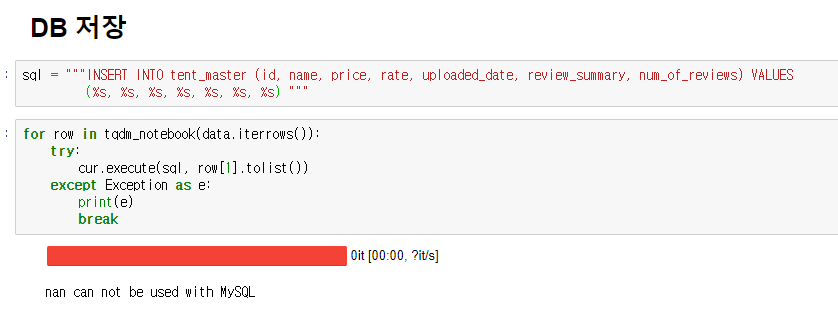

In [35]:
data[data['rate'].isnull()]

,id,name,price,rate,uploaded_date,review_summary,num_of_reviews
74,32255706618,카즈미 아크로 돔 엣지 K221T3T06 3-4인용,258700,None,20220510142121,,0
130,84208833096,노스피크 에어텐트 A7 A6 A5 옐로우스톤하이브리드 에어리빙쉘터 도킹쉘터 네오어닝,1290000,None,20220512152938,,0
149,83944706475,돔쉘터 쉘터텐트 글램핑 장박 대형 텐트,189000,None,20220311160120,,0


In [41]:
data = data.replace(np.nan, 'Null')

In [42]:
data[data['rate'].isnull()]

,id,name,price,rate,uploaded_date,review_summary,num_of_reviews


# DB 연결

In [7]:
try:
    con = pymysql.connect(host='xx.ap-northeast-2.rds.amazonaws.com', user='xx', password='xx' 
                          ,port=3306, database = 'crawling', use_unicode=True, charset='utf8')
    cur = con.cursor()
except Exception as e:
    print (e)

# DB 저장

In [8]:
sql = """INSERT INTO tent_master (id, name, price, rate, uploaded_date, review_summary, num_of_reviews) VALUES
         (%s, %s, %s, %s, %s, %s, %s) """

In [43]:
for row in tqdm_notebook(data.iterrows()):
    try:
        cur.execute(sql, row[1].tolist())
    except Exception as e:
        print(e)
        break

In [44]:
con.commit()

In [128]:
df = data.copy()

In [10]:
df = df.astype({"price": "int64", "uploaded_date": 'datetime64[ns]'}, errors='ignore')

In [5]:
df.to_parquet('./product_information.parquet', compression='gzip')

NameError: name 'df' is not defined

In [2]:
product_information = pd.read_parquet('./product_information.parquet')

In [3]:
print(product_information)

              id                                        name    price  rate  \
0    11180765626                        로티캠프 원터치 육각 텐트 4-5인용    73880   4.7   
1    21722796480                  블루오션 그라비티 패밀리 원터치 텐트 4-5인용    74900   4.8   
2    27412943522                    DOD 가마보코텐트 3M T5-689 5인용  1080000   4.9   
3    14981947918                     아이두젠 패스트캠프 원터치 육각텐트 오토6    66380   4.7   
4    19377657299                       로티캠프 빅스퀘어 원터치텐트 5-6인용   153410   4.7   
..           ...                                         ...      ...   ...   
195  18863778738                 콜맨 터프돔 3025  플러스 2000033133   503000   4.8   
196  32320864744                 노스피크 에어리빙쉘터 레이븐그레이 (4인용 텐트)   749000   NaN   
197  32695616618                   코베아 BTS-ON 레트로 하우스 텐트 4인용   890000   NaN   
198  83725038236  코베아 몬타나 쉘터 2 / 아이보리 탄 / 미니멀 캠핑 쉘터 / 코베아공식점   480000   4.7   
199  83138690669       테라네이션 카우코후 플러스 레카코후 원터치 한강 피크닉 그늘막 텐트   198000   4.9   

          uploaded_date                            

In [127]:
data.to_csv('./tent_master.csv')

### review_top_200

In [4]:
review_top_200 = product_information.sort_values(by=['num_of_reviews'], ascending=False)[0:201].copy()

In [4]:
review_top_200 = review_top_200[['id', 'num_of_reviews']].copy()

In [9]:
review_top_200.to_csv('./review_top_200.csv')

In [5]:
review_top_200 = pd.read_csv('./review_top_200.csv')

# <상품 id별 리뷰 받기>

!!주의사항!! <br>
1. 네이버의 정책상 최대 2000개의 리뷰(100 페이지의 양)만을 제공 <br>
    -> 자동화 시 전체 리뷰수를 파악한 후 page 범위가 100을 넘지 않도록 설정할 것 <br>
2. 100페이지를 한 번에 request 했더니 Connection Error 발생. 최대 크롤링 횟수를 초과한 것으로 보임<br>
    -> 상품 id와 페이지 숫자를 가지고 한 페이지씩(20개 리뷰) 결과 반환하도록 함

### 상품id를 넣으면 전체 페이지 수 반환 (네이버에서 허용하는 최대 수는 100)

In [6]:
prd_ids = list(product_information['id'])

In [7]:
prd_ids

['11180765626',
 '21722796480',
 '27412943522',
 '14981947918',
 '19377657299',
 '21722689805',
 '22228742235',
 '27413049522',
 '29896064618',
 '10153311431',
 '23590593493',
 '14958064919',
 '27408394523',
 '27011310522',
 '23716114495',
 '17862518718',
 '26084698522',
 '19452840658',
 '27286796522',
 '7832428090',
 '20909208466',
 '9838430423',
 '27473162523',
 '21033853139',
 '27810512522',
 '27413093522',
 '22895277426',
 '23937348523',
 '26527693522',
 '23199854491',
 '24161809523',
 '19134145855',
 '23462593491',
 '20744829040',
 '24824177522',
 '22412166138',
 '6916437886',
 '19751131585',
 '30487095618',
 '27627425528',
 '27820960522',
 '31467035618',
 '30942124618',
 '31352879625',
 '29738100618',
 '82689513777',
 '83264816669',
 '82393642663',
 '22823538427',
 '30016082618',
 '32695611628',
 '83148546349',
 '23604329500',
 '82955658212',
 '20931662172',
 '29226921620',
 '18467395766',
 '83225694955',
 '83793773940',
 '83525540379',
 '32085914618',
 '5635138587',
 '2278221532

In [5]:
def get_page_num(prd_id):
    num_of_review = int(product_information[product_information['id'] == prd_id]['num_of_reviews'])
    num_of_page_by_20 = num_of_review//20
    print(prd_id, ': ', num_of_page_by_20)

In [6]:
get_page_num(prd_ids[0])

11180765626 :  372


In [10]:
get_page_num('9838430423')

9838430423 :  53


### 하나의 페이지의 20개의 리뷰를 DataFrame 형태로 저장

In [132]:
def get_reviews_by_page(prd_id, page_num):
    cookies = {
    'NNB': 'IDMGADL3MHIWC',
    'AD_SHP_BID': '27',
    '_ga_4BKHBFKFK0': 'GS1.1.1642402376.2.1.1642402379.0',
    'ASID': 'dc763f370000017e66d652af00000061',
    'MM_NEW': '1',
    'NFS': '2',
    '_ga': 'GA1.2.2106199447.1642400290',
    '_ga_7VKFYR6RV1': 'GS1.1.1645429964.2.0.1645429964.60',
    'autocomplete': 'use',
    'nx_ssl': '2',
    'ncpa': '"6148|l2e3zkv4|cdf8e41eb25f6af897ae99fe3fa6ed973aebe219|s_124fd409a50b|c1c4719e7921bf013624130d6d96c1956ac7b3b2:95694|l2ucqnlk|51bfe6675daed5b2a745736a747eb9ec6419ddad|95694|0d82818b487a4e234125e83eec99c34021630735"',
    'sus_val': 'S0F1UsdM+HwwniR8Tq3qX19O',
    'spage_uid': '',
    }

    headers = {
        'authority': 'search.shopping.naver.com',
        'accept': 'application/json, text/plain, */*',
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        # Requests sorts cookies= alphabetically
        # 'cookie': 'NNB=IDMGADL3MHIWC; AD_SHP_BID=27; _ga_4BKHBFKFK0=GS1.1.1642402376.2.1.1642402379.0; ASID=dc763f370000017e66d652af00000061; MM_NEW=1; NFS=2; _ga=GA1.2.2106199447.1642400290; _ga_7VKFYR6RV1=GS1.1.1645429964.2.0.1645429964.60; autocomplete=use; nx_ssl=2; ncpa="6148|l2e3zkv4|cdf8e41eb25f6af897ae99fe3fa6ed973aebe219|s_124fd409a50b|c1c4719e7921bf013624130d6d96c1956ac7b3b2:95694|l2ucqnlk|51bfe6675daed5b2a745736a747eb9ec6419ddad|95694|0d82818b487a4e234125e83eec99c34021630735"; sus_val=S0F1UsdM+HwwniR8Tq3qX19O; spage_uid=',
        'referer': 'https://search.shopping.naver.com/catalog/11180765626?query=%ED%85%90%ED%8A%B8&NaPm=ct%3Dl2pqilo8%7Cci%3D692b32d7f59460de272136a51743c0fdfcd658f0%7Ctr%3Dslsl%7Csn%3D95694%7Chk%3D8608eff24f89eb17897e60155517dc3307ffcd6e',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="101", "Google Chrome";v="101"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.54 Safari/537.36',
    }

    params = {
        'nvMid': prd_id,
        'reviewType': 'ALL',
        'sort': 'QUALITY',
        'isNeedAggregation': 'N',
        'isApplyFilter': 'N',
        'page': page_num,
        'pageSize': '20',
    }

    response = requests.get('https://search.shopping.naver.com/api/review', params=params, cookies=cookies, headers=headers)
    reviewlist = json.loads(response.text)
    
    list_reviews = []
    
    for i in range(0, 20):
        
        list_review = []
        
        # prd_id
        if 'matchNvMid' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['matchNvMid'])
        else:
            list_review.append("NaN")
        
        # prd_url
        if 'pageUrl' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['pageUrl'])
        else:
            list_review.append("NaN")
            
        # user_id
        if 'userId' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['userId'])
        else:
            list_review.append("NaN")
        
        # content
        if 'content' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['content'])
        else:
            list_review.append("NaN")
        
        # register_date
        if 'registerDate' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['registerDate'])
        else:
            list_review.append("NaN")
        
        # quality_score
        if 'qualityScore' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['qualityScore'])
        else:
            list_review.append("NaN")
            
        # star_score
        if 'starScore' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['starScore'])
        else:
            list_review.append("NaN")
        
        # image_url
        if 'images' in reviewlist['reviews'][i]:
            list_review.append(reviewlist['reviews'][i]['images'])
        else:
            list_review.append("NaN")
        
        list_reviews.append(list_review)
    
    cols = ['prd_id', 'prd_url', 'user_id', 'review', 'uploaded_date', 'quality_score', 'star_score', 'image_url']   
    return pd.DataFrame(list_reviews, columns = cols)

In [116]:
"""def save_to_s3(p1_col, prd_id):
    s3 = boto3.client('s3')
    bucket_name = 'xx'
    bucket_path = "tent"
    aws_access_key_id = 'xx'
    aws_secret_access_key= 'xx'
    
    total_img_num = 0
    for idx in range(len(p1['image_url'])):
        url = p1['image_url'][idx][0]
        if len(url) > 1:
            imageResponse = requests.get(url, stream=True).raw
            file_name = "{}/{}-{}.jpg".format(bucket_path, prd_id, idx)
            s3.upload_fileobj(imageResponse, bucket_name, file_name)
            total_img_num += 1
    print(total_img_num)"""

In [133]:
get_page_num('29896064618')

NameError: name 'get_page_num' is not defined

# DF 병합

In [134]:
def review_save(prd_id, page_end_num):
    list_df = []
    for i in range(1, page_end_num+1):
        list_df.append(get_reviews_by_page(prd_id, i))
    df = pd.concat(list_df)
    df['image_url'] = df['image_url'].astype(str)
    return df

# <RDS mysql에 저장>

### DB 정보

In [60]:
try:
    con = pymysql.connect(host='xx.ap-northeast-2.rds.amazonaws.com', user='xx', password='xx' 
                          ,port=3306, database = 'crawling', use_unicode=True, charset='utf8')
    cur = con.cursor()
except Exception as e:
    print (e)

In [61]:
sql = """INSERT INTO tent_review (prd_id, prd_url, user_id, review, uploaded_date, quality_score, star_score, image_url) VALUES
         (%s, %s, %s, %s, %s, %s, %s, %s) """

## DB 저장

In [555]:
for row in tqdm_notebook(df.iterrows()):
    try:
        cur.execute(sql, row[1].tolist())
    except Exception as e:
        print(e)
        break

In [556]:
con.commit()

# <S3에 이미지 업로드>

### 버킷 정보

In [17]:
# 연결 확인

s3_resource = boto3.resource('s3')
for bucket in s3_resource.buckets.all():
    print(bucket.name)

j-crawling-images-team
smartstore-data


In [45]:
def save_to_s3(p1_col, prd_id):
    s3 = boto3.client('s3')
    bucket_name = 'xx'
    bucket_path = "tent"
    aws_access_key_id = 'xx'
    aws_secret_access_key= 'xx'
    
    total_img_num = 0
    for idx in range(len(p1['image_url'])):
        url = p1['image_url'][idx][0]
        if len(url) > 1:
            imageResponse = requests.get(url, stream=True).raw
            file_name = "{}/{}-{}.jpg".format(bucket_path, prd_id, idx)
            s3.upload_fileobj(imageResponse, bucket_name, file_name)
            total_img_num += 1
    print(total_img_num)

## 버킷 저장

In [61]:
p1 = get_reviews_by_page('24094588525', 1)

In [62]:
save_to_s3(p1['image_url'], '24094588525')

11


# 상품별로

In [721]:
def get_reviews_by_prd(prd_id, page_num):
    cookies = {
    'NNB': 'IDMGADL3MHIWC',
    '_ga_4BKHBFKFK0': 'GS1.1.1642402376.2.1.1642402379.0',
    'ASID': 'dc763f370000017e66d652af00000061',
    'MM_NEW': '1',
    'NFS': '2',
    '_ga': 'GA1.2.2106199447.1642400290',
    '_ga_7VKFYR6RV1': 'GS1.1.1645429964.2.0.1645429964.60',
    '_gcl_au': '1.1.914543992.1653449299',
    '_fbp': 'fb.1.1653449299150.1579184898',
    'nx_ssl': '2',
    'nid_inf': '1769979884',
    'NID_AUT': '8uGr2sf5lWmTGcYZE5y6WkKCrYk6a8aR/EjFHGWmfSKnsB56PbkDRc7SzqvMl9Yf',
    'NID_JKL': '4e87ZCWcbP8Vh0J55HZLP4NK7qScYcuL//TPXne/xA4=',
    'NID_SES': 'AAABebyPiAHj295pemW8645xRcq5nK05nIeh16AZmpFZsmEjVubVwVf9492m35MR7v18cIOjvXZEsJhvazK+dzQQakMu43FU2XFC8OKJcnJi/XjyOarGFvJ2R2sSSTxrZuBF/0o8yeahcm0mwB8dBvhkuRaNbpfQz8jDcAJwmt/080symgsXiRoKI6HkbgTZEaU4rbC/6OPpSYc60VwauQMGMRZ1nLXXQVAXRJ22HJtbY0/9dcXDRXOadyFPVGef3vT7X6fNB6EG2W0EfG6N1ZlUP9AfqEcZyXjOTgU2HZnuWN5pZbd3wz3+RjCVZbQKD2S+2kG6zEKTMr7Hu5EK1YPCctU2Fyo+xCHN2Vl/yrBF9MXgETzU3HADRn1h3u5vSCXdQs/XB5rgCWBNkZKAgzbugOQEqhwh/2QUh3RRboMr12ar4abnBzr7B8fmxK0j0fPsBBaBVKTJ6s4cLrhY+nhwLt/+J5JUgdYbbhNeQOpXlaOClvmx2oZh60OCjArs4zJlJQ==',
    'page_uid': 'hqecRsprvxZssO2oXKwssssst/Z-417643',
    }

    headers = {
        'authority': 'smartstore.naver.com',
        'accept': 'application/json, text/plain, */*',
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        # Requests sorts cookies= alphabetically
        # 'cookie': 'NNB=IDMGADL3MHIWC; _ga_4BKHBFKFK0=GS1.1.1642402376.2.1.1642402379.0; ASID=dc763f370000017e66d652af00000061; MM_NEW=1; NFS=2; _ga=GA1.2.2106199447.1642400290; _ga_7VKFYR6RV1=GS1.1.1645429964.2.0.1645429964.60; _gcl_au=1.1.914543992.1653449299; _fbp=fb.1.1653449299150.1579184898; nx_ssl=2; nid_inf=1769979884; NID_AUT=8uGr2sf5lWmTGcYZE5y6WkKCrYk6a8aR/EjFHGWmfSKnsB56PbkDRc7SzqvMl9Yf; NID_JKL=4e87ZCWcbP8Vh0J55HZLP4NK7qScYcuL//TPXne/xA4=; NID_SES=AAABebyPiAHj295pemW8645xRcq5nK05nIeh16AZmpFZsmEjVubVwVf9492m35MR7v18cIOjvXZEsJhvazK+dzQQakMu43FU2XFC8OKJcnJi/XjyOarGFvJ2R2sSSTxrZuBF/0o8yeahcm0mwB8dBvhkuRaNbpfQz8jDcAJwmt/080symgsXiRoKI6HkbgTZEaU4rbC/6OPpSYc60VwauQMGMRZ1nLXXQVAXRJ22HJtbY0/9dcXDRXOadyFPVGef3vT7X6fNB6EG2W0EfG6N1ZlUP9AfqEcZyXjOTgU2HZnuWN5pZbd3wz3+RjCVZbQKD2S+2kG6zEKTMr7Hu5EK1YPCctU2Fyo+xCHN2Vl/yrBF9MXgETzU3HADRn1h3u5vSCXdQs/XB5rgCWBNkZKAgzbugOQEqhwh/2QUh3RRboMr12ar4abnBzr7B8fmxK0j0fPsBBaBVKTJ6s4cLrhY+nhwLt/+J5JUgdYbbhNeQOpXlaOClvmx2oZh60OCjArs4zJlJQ==; page_uid=hqecRsprvxZssO2oXKwssssst/Z-417643',
        'referer': 'https://smartstore.naver.com/blueoceankl/products/{}?NaPm=ct%3Dl49kr2c0%7Cci%3D5561ccf2664570e57c33072091c5f0ba53aa518d%7Ctr%3Dslsl%7Csn%3D697628%7Chk%3D17e46c4e38832e3acbb51112f4857f900ca925cc'.format(prd_id),
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    }

    params = {
        'page': page_num,
        'pageSize': '20',
        'merchantNo': '510168447',
        'originProductNo': '4547615294',
        'sortType': 'REVIEW_RANKING',
    }

    response = requests.get('https://smartstore.naver.com/i/v1/reviews/paged-reviews', params=params, cookies=cookies, headers=headers)
    reviewlist = json.loads(response.text)
    
    
    list_reviews = []
    
    for i in range(0, 20):
        
        list_review = []
        
        # prd_id
        if 'productNo' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['productNo'])
        else:
            list_review.append("NaN")
        
        # prd_url
        if 'productUrl' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['productUrl'])
        else:
            list_review.append("NaN")
            
        # user_id
        if 'writerMemberId' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['writerMemberId'])
        else:
            list_review.append("NaN")
        
        # content
        if 'reviewContent' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['reviewContent'])
        else:
            list_review.append("NaN")
        
        # register_date
        if 'createDate' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['createDate'])
        else:
            list_review.append("NaN")
        
        # quality_score
        list_review.append('NaN')
            
        # star_score
        if 'reviewScore' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['reviewScore'])
        else:
            list_review.append("NaN")
        
        # image_url
        list_review.append("NaN")
        
        list_reviews.append(list_review)
    
    cols = ['prd_id', 'prd_url', 'user_id', 'review', 'uploaded_date', 'quality_score', 'star_score', 'image_url']   
    return pd.DataFrame(list_reviews, columns = cols)

In [51]:
def review_save_by_prd(prd_id, page_end_num):
    list_df = []
    for i in range(1, page_end_num+1):
        list_df.append(get_reviews_by_prd(prd_id, i))
    df = pd.concat(list_df)
    return df

In [738]:
df = review_save_by_prd('100408682', 101)
print(len(df))

2020


In [739]:
for row in tqdm_notebook(df.iterrows()):
    try:
        cur.execute(sql, row[1].tolist())
    except Exception as e:
        print(e)
        break

In [740]:
con.commit()

# prd_id없이 각 상품별로 저장

In [120]:
def get_reviews_by_prd(page_num):
    cookies = {
    'NNB': 'IDMGADL3MHIWC',
    '_ga_4BKHBFKFK0': 'GS1.1.1642402376.2.1.1642402379.0',
    'ASID': 'dc763f370000017e66d652af00000061',
    'MM_NEW': '1',
    'NFS': '2',
    '_ga': 'GA1.2.2106199447.1642400290',
    '_ga_7VKFYR6RV1': 'GS1.1.1645429964.2.0.1645429964.60',
    '_gcl_au': '1.1.914543992.1653449299',
    '_fbp': 'fb.1.1653449299150.1579184898',
    'nx_ssl': '2',
    'nid_inf': '1769979884',
    'NID_AUT': '8uGr2sf5lWmTGcYZE5y6WkKCrYk6a8aR/EjFHGWmfSKnsB56PbkDRc7SzqvMl9Yf',
    'NID_JKL': '4e87ZCWcbP8Vh0J55HZLP4NK7qScYcuL//TPXne/xA4=',
    'NID_SES': 'AAABelVhj3YjlOLnqiY9BMFo0J5kvSIo4/SFZ2J6+f/BLOy22UlURxs/m8pWz75vToPNEZ9vLtisB4svHyIO7N+vBvjTvneycRgMqb9GRmAjUtksRkJDP1JW8CqHI9yt5XBgeSX99CttAX11Geqy2pq+3S0ZeGc0XPwqwPpBrnu38l7h1nG+vePl++ZxZyaNQcstlAdHz0TAlpdNVK+4jHuuWypg4C5/1112w6XXDmNGJmK0gsEceQUc4NIjR5C+Tze1KwC3cset+lJ3kucRltdDlISmQ14OMyf2j48stQCI+8uQYMY/1qqlQcQzrCzn4bvxzQrUKYZDgcwmoSKfD1EA73Ww0GSiV9V/c1kgbuHNfXTN9g2rukd72unUpPzhRjqtfOEaVtJCJ7Jj0cXgg9iyIQCGM3kgVoCyZ8kDd/St6l0/8BUJQ935ussCgp1Y1arLxyxcg08H6JDGvXipZZUgKOMQlyW6CXa/+pi6RqaaoCreTUnfTC/19SFY5pNaxS+JJA==',
    'page_uid': 'hqSl8wprvmssst1cuoZssssss4R-066107',
    }

    headers = {
        'authority': 'smartstore.naver.com',
        'accept': 'application/json, text/plain, */*',
        'accept-language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        # Requests sorts cookies= alphabetically
        # 'cookie': 'NNB=IDMGADL3MHIWC; _ga_4BKHBFKFK0=GS1.1.1642402376.2.1.1642402379.0; ASID=dc763f370000017e66d652af00000061; MM_NEW=1; NFS=2; _ga=GA1.2.2106199447.1642400290; _ga_7VKFYR6RV1=GS1.1.1645429964.2.0.1645429964.60; _gcl_au=1.1.914543992.1653449299; _fbp=fb.1.1653449299150.1579184898; nx_ssl=2; nid_inf=1769979884; NID_AUT=8uGr2sf5lWmTGcYZE5y6WkKCrYk6a8aR/EjFHGWmfSKnsB56PbkDRc7SzqvMl9Yf; NID_JKL=4e87ZCWcbP8Vh0J55HZLP4NK7qScYcuL//TPXne/xA4=; NID_SES=AAABelVhj3YjlOLnqiY9BMFo0J5kvSIo4/SFZ2J6+f/BLOy22UlURxs/m8pWz75vToPNEZ9vLtisB4svHyIO7N+vBvjTvneycRgMqb9GRmAjUtksRkJDP1JW8CqHI9yt5XBgeSX99CttAX11Geqy2pq+3S0ZeGc0XPwqwPpBrnu38l7h1nG+vePl++ZxZyaNQcstlAdHz0TAlpdNVK+4jHuuWypg4C5/1112w6XXDmNGJmK0gsEceQUc4NIjR5C+Tze1KwC3cset+lJ3kucRltdDlISmQ14OMyf2j48stQCI+8uQYMY/1qqlQcQzrCzn4bvxzQrUKYZDgcwmoSKfD1EA73Ww0GSiV9V/c1kgbuHNfXTN9g2rukd72unUpPzhRjqtfOEaVtJCJ7Jj0cXgg9iyIQCGM3kgVoCyZ8kDd/St6l0/8BUJQ935ussCgp1Y1arLxyxcg08H6JDGvXipZZUgKOMQlyW6CXa/+pi6RqaaoCreTUnfTC/19SFY5pNaxS+JJA==; page_uid=hqSl8wprvmssst1cuoZssssss4R-066107',
        'referer': 'https://smartstore.naver.com/seland/products/2471807188?NaPm=ct%3Dl4asulkg%7Cci%3Dd2dda3b0d841e0c465eaabe2382786b1c697a6f6%7Ctr%3Dslsl%7Csn%3D205012%7Chk%3D17761402e36205bf00e83ba95101e6cdb09f577b',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    }

    params = {
        'page': page_num,
        'pageSize': '20',
        'merchantNo': '500032759',
        'originProductNo': '2469219281',
        'sortType': 'REVIEW_RANKING',
    }

    response = requests.get('https://smartstore.naver.com/i/v1/reviews/paged-reviews', params=params, cookies=cookies, headers=headers)
    reviewlist = json.loads(response.text)
    
    
    list_reviews = []
    
    for i in range(0, 20):
        
        list_review = []
        
        # prd_id
        if 'productNo' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['productNo'])
        else:
            list_review.append("NaN")
        
        # prd_url
        if 'productUrl' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['productUrl'])
        else:
            list_review.append("NaN")
            
        # user_id
        if 'writerMemberId' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['writerMemberId'])
        else:
            list_review.append("NaN")
        
        # content
        if 'reviewContent' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['reviewContent'])
        else:
            list_review.append("NaN")
        
        # register_date
        if 'createDate' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['createDate'])
        else:
            list_review.append("NaN")
        
        # quality_score
        list_review.append('NaN')
            
        # star_score
        if 'reviewScore' in reviewlist['contents'][i]:
            list_review.append(reviewlist['contents'][i]['reviewScore'])
        else:
            list_review.append("NaN")
        
        # image_url
        list_review.append("NaN")
        
        list_reviews.append(list_review)
    
    cols = ['prd_id', 'prd_url', 'user_id', 'review', 'uploaded_date', 'quality_score', 'star_score', 'image_url']   
    return pd.DataFrame(list_reviews, columns = cols)

In [65]:
def review_save_by_prd(page_end_num):
    list_df = []
    for i in range(1, page_end_num+1):
        list_df.append(get_reviews_by_prd(i))
    df = pd.concat(list_df)
    return df

In [121]:
df = review_save_by_prd(19)
print(len(df))

380


In [122]:
df.head()

,prd_id,prd_url,user_id,review,uploaded_date,quality_score,star_score,image_url
0,2471807188,https://smartstore.naver.com/main/products/247...,micr****,부모님 캠핑하시는데 넘 만족하시네요,2021-05-06T08:12:25.900+00:00,NaN,5,NaN
1,2471807188,https://smartstore.naver.com/main/products/247...,va****,아이들이 좋다고 하네요,2021-04-09T09:01:40.026+00:00,NaN,5,NaN
2,2471807188,https://smartstore.naver.com/main/products/247...,bhje*****,벙커돔 두번째구매입니다. 역시나 설치중에 루프플라이 고리가 하나 끊어졌네요ㅜㅜ예전에...,2021-03-13T06:06:26.797+00:00,NaN,4,NaN
3,2471807188,https://smartstore.naver.com/main/products/247...,pree***,벙커돔치곤 가볍게 사용하기 좋습니다~! 백패킹용으로 들고다니기엔 무게가 좀 있긴 하...,2021-03-02T04:53:39.500+00:00,NaN,4,NaN
4,2471807188,https://smartstore.naver.com/main/products/247...,ksho******,설치도 쉽고 만족합니다,2021-03-29T06:21:12.387+00:00,NaN,5,NaN


In [123]:
for row in tqdm_notebook(df.iterrows()):
    try:
        cur.execute(sql, row[1].tolist())
    except Exception as e:
        print(e)
        break

In [124]:
con.commit()